# Load all imports

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import helper
import net

# Globals, CNNs, and Device

In [3]:
oriPATH = 'C:/Users/Ryan/Desktop/machine-learning/part2/cnn'

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
learningRates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
numEpochs = 25

adamNets = helper.createNets(len(learningRates), 'sig')
sgdNets = helper.createNets(len(learningRates), 'sig')
print(sum([p.numel() for p in adamNets[0].parameters()]))
print(sum([p.numel() for p in sgdNets[0].parameters()]))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

for i in range(len(learningRates)):
    adamNets[i] = adamNets[i].to(device)
    sgdNets[i] = sgdNets[i].to(device)

884330
884330
cuda:0


# MNIST training and validation set augmentation

In [3]:
valid_ratio = 0.3

transform = transforms.Compose([
    # define your data augmentation here!
    # transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_valid_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True, num_workers=2, pin_memory=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1000, shuffle=True, num_workers=2, pin_memory=True)

# Define the loss function and the optimizer.

In [4]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# define your optimizer and its learning rate (lr) here!
adams, sgds = helper.createOptimizers(adamNets, sgdNets, learningRates)

# Train the CNN and store the best model based on the validation loss.

In [5]:
import os as OO
OO.mkdir(PATH + '/task1')
PATH = oriPATH + '/task1'

adamTrainingLoss = []
adamValidationLoss = []
sgdTrainingLoss = []
sgdValidationLoss = []

for i in range(len(learningRates)):
    %time train, val = helper.runCNN(trainloader, device, adams[i], adamNets[i], criterion, validloader, PATH, 'adam', numEpochs)
    adamTrainingLoss.append(train)
    adamValidationLoss.append(val)

for i in range(len(learningRates)):
    %time train, val = helper.runCNN(trainloader, device, sgds[i], sgdNets[i], criterion, validloader, PATH, 'sgd', numEpochs)
    sgdTrainingLoss.append(train)
    sgdValidationLoss.append(val)

np.save(OO.path.join(PATH, 'adamTrainingLoss.npy'), adamTrainingLoss)
np.save(OO.path.join(PATH, 'adamValidationLoss.npy'), adamValidationLoss)
np.save(OO.path.join(PATH, 'sgdTrainingLoss.npy'), sgdTrainingLoss)
np.save(OO.path.join(PATH, 'sgdValidationLoss.npy'), sgdValidationLoss)

Wall time: 2min 39s
Wall time: 2min 37s
Wall time: 2min 38s
Wall time: 2min 38s
Wall time: 2min 39s
Wall time: 2min 38s
Wall time: 2min 38s
Wall time: 2min 39s
Wall time: 2min 39s
Wall time: 2min 39s


# Define the test dataset.

In [6]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))
])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Infer on the whole test dataset.

In [7]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=2, pin_memory=True)

import os as OO
PATH = oriPATH + '/task1'

adamAccuracy = []
sgdAccuracy = []

def printAccuracies(accuracy, testNet, kind, optimizers):
    for i in range(len(learningRates)):    
        temp = []
        newPath = PATH + "/{}_lr_{}".format(kind, optimizers[i].defaults['lr'])
        for j in range(numEpochs):
            fileName = "{}_epoch_{}_lr_{}.pth".format(kind, j, learningRates[i])
            testNet.load_state_dict(torch.load(OO.path.join(newPath, fileName)))
            correct, total = helper.testCNN(testloader, testNet, device)
            temp.append(100 * correct / total)
        accuracy.append(temp)


testNet = net.SigNet()
testNet = testNet.to(device)
printAccuracies(adamAccuracy, testNet, 'adam', adams)

testNet = net.ReluNet()
testNet = testNet.to(device)
printAccuracies(sgdAccuracy, testNet, 'sgd', sgds)

aTrain = np.load(OO.path.join(PATH, 'adamTrainingLoss.npy'))
aVal = np.load(OO.path.join(PATH, 'adamValidationLoss.npy'))
sTrain = np.load(OO.path.join(PATH, 'sgdTrainingLoss.npy'))
sVal = np.load(OO.path.join(PATH, 'sgdValidationLoss.npy'))

# Graph Training Losses and Accuracy

Text(0, 0.5, 'Training Loss')

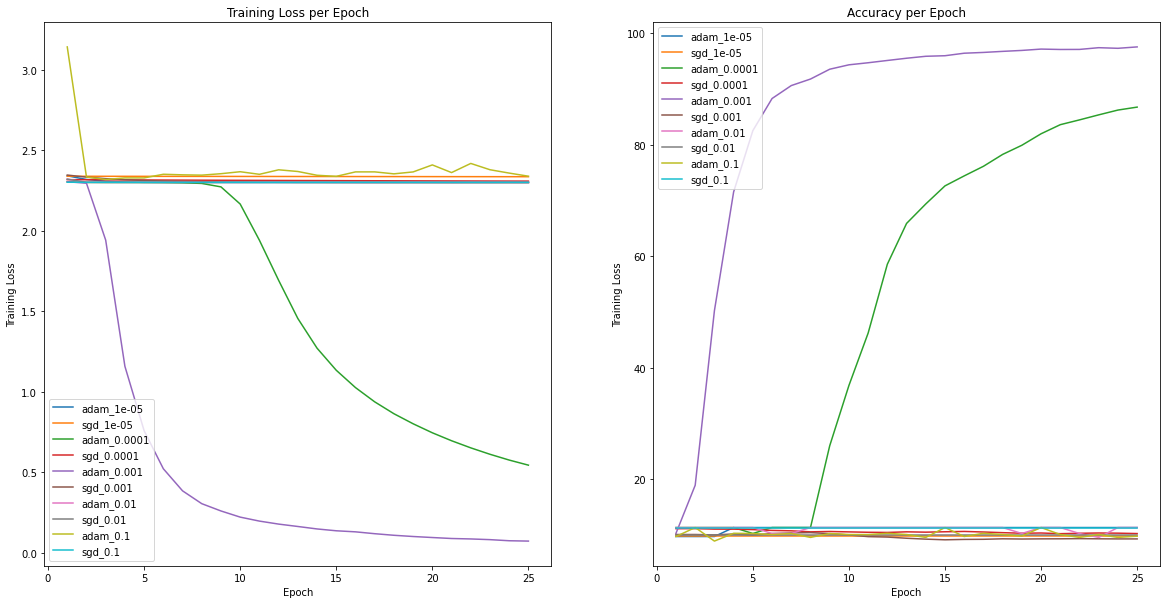

In [9]:
import numpy as np
import matplotlib.pyplot as plt

epochs = range(1, numEpochs + 1)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

for i in range(len(learningRates)):
    ax[0].plot(epochs, aTrain[i], label='adam_{}'.format(learningRates[i]))
    ax[0].plot(epochs, sTrain[i], label='sgd_{}'.format(learningRates[i]))

for i in range(len(learningRates)):
    ax[1].plot(epochs, adamAccuracy[i], label='adam_{}'.format(learningRates[i]))
    ax[1].plot(epochs, sgdAccuracy[i], label='sgd_{}'.format(learningRates[i]))

ax[0].legend(loc="lower left")
ax[1].legend(loc="upper left")

ax[0].set_title("Training Loss per Epoch")
ax[1].set_title("Accuracy per Epoch")

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Training Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Training Loss")

I trained 5 learning rates on 2 different optimizers for 25 epochs each.  Here, we see that the learning rates outside of 0.0001 and 0.001 tend to not be able to converge.  That range appears to be the 'sweet' spot to get the network to optimize well.  It looks like 0.001 will net faster convergence speed than 0.0001 though.